In [1]:
import tensorflow as tf
from cam_generator import ScoreCamSaliency
from keras.utils import load_img, img_to_array
from keras.applications.vgg16 import decode_predictions
import matplotlib.pyplot as plt
import numpy as np

model = tf.keras.applications.vgg16.VGG16(weights="imagenet")
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [2]:
img_file = "images/dog_and_cat.png"
img = load_img("img_file", target_size=(224, 224))
ary = img_to_array(img)

FileNotFoundError: [Errno 2] No such file or directory: 'img_file'

In [9]:
pred = model.predict(ary[np.newaxis, :, :, :])
n = np.argmax(pred)
layer_name = "block5_conv3"
results = decode_predictions(pred, top=5)[0]
for result in results:
    print(result)
score_cam = ScoreCamSaliency(model, n, "block5_conv3")

1/1 [==============================] - 0s 102ms/step
('n02091134', 'whippet', 0.3000683)
('n02110958', 'pug', 0.27928314)
('n02092339', 'Weimaraner', 0.07443811)
('n02108422', 'bull_mastiff', 0.068620875)
('n02109047', 'Great_Dane', 0.051463276)


In [10]:
act_map, y = score_cam(ary[np.newaxis, :, :, :])

16/16 [==============================] - 31s 2s/step
[-0.2998981  -0.29984507 -0.2999399  -0.29717603 -0.29952708 -0.29979682
 -0.2987087  -0.29984054 -0.29975992 -0.29995462 -0.29922372 -0.29976594
 -0.3000514  -0.29717603 -0.2995394  -0.2992522  -0.299867   -0.29952583
 -0.29717603 -0.299206   -0.29972216 -0.2992769  -0.29717603 -0.2999156
 -0.29921764 -0.29978853 -0.2993816  -0.2991087  -0.29993904 -0.29976907
 -0.299776   -0.30000117 -0.29955015 -0.2993893  -0.2998071  -0.29717603
 -0.29929468 -0.29979435 -0.29986188 -0.29979554 -0.2997884  -0.29717603
 -0.30002758 -0.29973525 -0.29994935 -0.2998224  -0.29826254 -0.29946417
 -0.29971683 -0.2991945  -0.29991382 -0.2997604  -0.30003187 -0.29717603
 -0.2991852  -0.29717603 -0.2986747  -0.29936168 -0.29948598 -0.2986633
 -0.29974338 -0.29717603 -0.2994401  -0.29958543 -0.29717603 -0.29717603
 -0.2990997  -0.29717603 -0.29819986 -0.2999659  -0.29990155 -0.29948518
 -0.29993606 -0.29717603 -0.29944897 -0.2998832  -0.29834965 -0.29996905


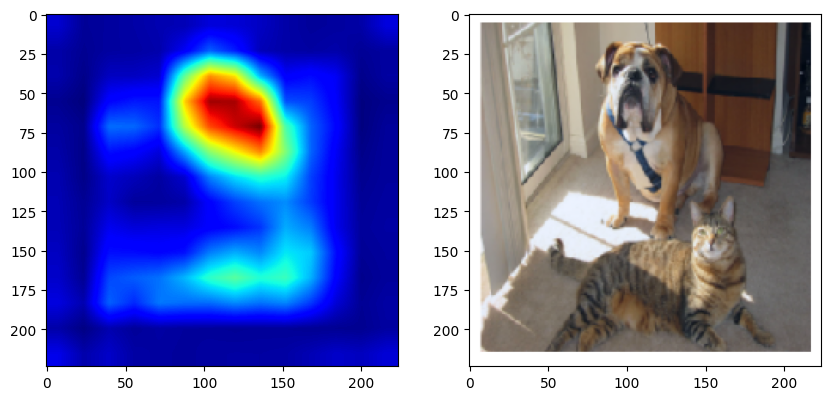

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(act_map[0], cmap="jet")
ax[1].imshow(ary/np.max(ary))

In [12]:
import cv2
import numpy as np
from keras.models import Model

def ScoreCam(model, img_array, layer_name, max_N=-1):

    cls = np.argmax(model.predict(img_array))
    cls = 109
    act_map_array = Model(inputs=model.input, outputs=model.get_layer(layer_name).output).predict(img_array)

    # extract effective maps
    if max_N != -1:
        act_map_std_list = [np.std(act_map_array[0,:,:,k]) for k in range(act_map_array.shape[3])]
        unsorted_max_indices = np.argpartition(-np.array(act_map_std_list), max_N)[:max_N]
        max_N_indices = unsorted_max_indices[np.argsort(-np.array(act_map_std_list)[unsorted_max_indices])]
        act_map_array = act_map_array[:,:,:,max_N_indices]

    input_shape = model.layers[0].output_shape[0]  # get input shape
    print(input_shape)
    # 1. upsampled to original input size
    act_map_resized_list = [cv2.resize(act_map_array[0,:,:,k], input_shape[1:3], interpolation=cv2.INTER_LINEAR) for k in range(act_map_array.shape[3])]
    # 2. normalize the raw activation value in each activation map into [0, 1]
    act_map_normalized_list = []
    for act_map_resized in act_map_resized_list:
        if np.max(act_map_resized) - np.min(act_map_resized) != 0:
            act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
        else:
            act_map_normalized = act_map_resized
        act_map_normalized_list.append(act_map_normalized)
    # 3. project highlighted area in the activation map to original input space by multiplying the normalized activation map
    masked_input_list = []
    for act_map_normalized in act_map_normalized_list:
        masked_input = np.copy(img_array)
        for k in range(3):
            masked_input[0,:,:,k] *= act_map_normalized
        masked_input_list.append(masked_input)
    masked_input_array = np.concatenate(masked_input_list, axis=0)
    # 4. feed masked inputs into CNN model and softmax
    pred_from_masked_input_array = softmax(model.predict(masked_input_array))
    # 5. define weight as the score of target class
    weights = pred_from_masked_input_array[:,cls]
    # 6. get final class discriminative localization map as linear weighted combination of all activation maps
    cam = np.dot(act_map_array[0,:,:,:], weights)
    cam = np.maximum(0, cam)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0

    return cam

def softmax(x):
    f = np.exp(x)/np.sum(np.exp(x), axis = 1, keepdims = True)
    return f


1/1 [==============================] - 0s 152ms/step
(None, 224, 224, 3)
16/16 [==============================] - 30s 2s/step


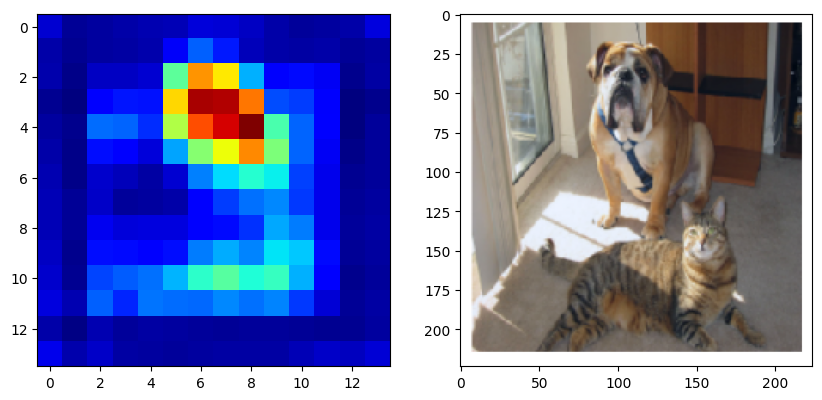

In [14]:
act_map = ScoreCam(model,ary[np.newaxis, :, :, :],layer_name)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(act_map, cmap="jet")
ax[1].imshow(ary/np.max(ary))